In [22]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [24]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [26]:
batch_size = 32
img_height = 180
img_width = 180

In [41]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [42]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [43]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [44]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [45]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [46]:
num_classes = len(class_names)
print(num_classes)

5


In [47]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [48]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [49]:
checkpoint_path = "Checkpoints/cp-{epoch:04d}.ckpt"

In [50]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq="epoch")

In [52]:
epochs = 35
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[cp_callback]
)

Epoch 1/35
92/92 [==============================] - ETA: 0s - loss: 0.9646 - accuracy: 0.6196
Epoch 1: saving model to Checkpoints\cp-0001.ckpt
92/92 [==============================] - 121s 1s/step - loss: 0.9646 - accuracy: 0.6196 - val_loss: 0.9679 - val_accuracy: 0.6213
Epoch 2/35
92/92 [==============================] - ETA: 0s - loss: 0.9020 - accuracy: 0.6427
Epoch 2: saving model to Checkpoints\cp-0002.ckpt
92/92 [==============================] - 121s 1s/step - loss: 0.9020 - accuracy: 0.6427 - val_loss: 0.9997 - val_accuracy: 0.6213
Epoch 3/35
92/92 [==============================] - ETA: 0s - loss: 0.8699 - accuracy: 0.6662
Epoch 3: saving model to Checkpoints\cp-0003.ckpt
92/92 [==============================] - 121s 1s/step - loss: 0.8699 - accuracy: 0.6662 - val_loss: 0.8882 - val_accuracy: 0.6553
Epoch 4/35
92/92 [==============================] - ETA: 0s - loss: 0.8105 - accuracy: 0.6884
Epoch 4: saving model to Checkpoints\cp-0004.ckpt
92/92 [===========================

In [53]:
model.save("./modelTest/")

INFO:tensorflow:Assets written to: ./modelTest/assets


INFO:tensorflow:Assets written to: ./modelTest/assets


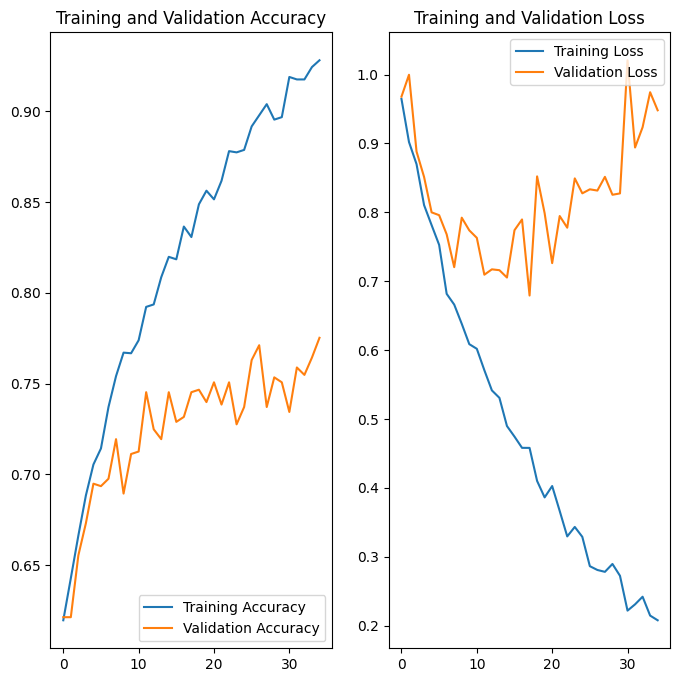

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [62]:
sunflower_path = "Predictions/tulip.jpg"

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 92ms/step
This image most likely belongs to tulips with a 99.96 percent confidence.
